# Experiment: Piecewise-linear approximation of VNF-PPs (Analysis)

Try to represent VNF-PPs as piece-wise linear functions.
The fitting is done using the [pwlf Python library](https://pypi.org/project/pwlf/).

Cite PWLF:

```latex
@Manual{pwlf,
    author = {Jekel, Charles F. and Venter, Gerhard},
    title = {{pwlf:} A Python Library for Fitting 1D Continuous Piecewise Linear Functions},
    year = {2019},
    url = {https://github.com/cjekel/piecewise_linear_fit_py}
}
```

## Segment number optimization

* Bayesian Optimization using [GPyOpt](https://sheffieldml.github.io/GPyOpt/)

```
@Misc{gpyopt2016,
  author =   {The GPyOpt authors},
  title =    {GPyOpt: A Bayesian Optimization framework in Python},
  howpublished = {\url{http://github.com/SheffieldML/GPyOpt}},
  year = {2016}
}
```

In [36]:
# basics
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np
np.random.seed(12121)
import pwlf
from GPyOpt.methods import BayesianOptimization

## Data Management
Load and clean the data sets to be easily used.

### Load data sets

In [37]:
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys
    of the mapping dict.
    It renames the columns to the values of the
    mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        #print("Renaming: {} -> {}".format(k, v))
        dff.rename(columns={k: v}, inplace=True)
    #print(dff.head())
    return dff

def cleanup(df):
    """
    Cleanup of df data.
    Dataset specific.
    """
    def _replace(df, column, str1, str2):
        if column in df:
            df[column] = df[column].str.replace(str1, str2)
            
    def _to_num(df, column):
        if column in df:
            df[column] = pd.to_numeric(df[column])
        
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/smallFlows.pcap", "0")   
    _replace(df, "flow_size", "tcpreplay -i data -tK --loop 40000 --preload-pcap /pcaps/bigFlows.pcap", "1")
    _to_num(df, "flow_size")
    _replace(df, "ruleset", "./start.sh small_ruleset", "1")
    _replace(df, "ruleset", "./start.sh big_ruleset", "2")
    _replace(df, "ruleset", "./start.sh", "0")
    _to_num(df, "ruleset")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "1")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "0")
    _replace(df, "req_size", "ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "1")
    _to_num(df, "req_size")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 1 --json /tngbench_share/malaria.json", "0")
    _replace(df, "req_type", "malaria publish -t -n 20000 -H 20.0.0.254 -q 2 --json /tngbench_share/malaria.json", "1")
    _replace(df, "req_type", "malaria publish -s 10 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "2")
    _replace(df, "req_type", "malaria publish -s 10000 -n 20000 -H 20.0.0.254 --json /tngbench_share/malaria.json", "3")
    _to_num(df, "req_type")
    
df_sec01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec01/data/csv_experiments.csv")
df_sec02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec02/data/csv_experiments.csv")
df_sec03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_sec03/data/csv_experiments.csv")
df_web01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web01/data/csv_experiments.csv")
df_web02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web02/data/csv_experiments.csv")
df_web03 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_web03/data/csv_experiments.csv")
df_iot01 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot01/data/csv_experiments.csv")
df_iot02 = pd.read_csv("/home/manuel/sndzoo/ds_nfv_iot02/data/csv_experiments.csv")

# do renaming and selection
map_sec01 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-suricata.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-suricata.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-suricata.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__suricata_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__suricata_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__suricata_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__suricata_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec02 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort2.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort2.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort2.0.1__mem_max": "memory",
    "metric__vnf0.vdu01.0__snort_bytes": "ids_bytes",
    "metric__vnf0.vdu01.0__snort_packets": "ids_pkts",
    "metric__vnf0.vdu01.0__snort_dropped": "ids_drop",
    #"metric__vnf0.vdu01.0__snort_drops": "ids_drops",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_sec03 = {
    "param__func__mp.input__cmd_start": "flow_size",
    "param__func__de.upb.ids-snort3.0.1__cmd_start": "ruleset",
    "param__func__de.upb.ids-snort3.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.ids-snort3.0.1__mem_max": "memory",
    #"metric__vnf0.vdu01.0__snort3_total_allow": "ids_allow",
    "metric__vnf0.vdu01.0__snort3_total_analyzed": "ids_pkts",
    "metric__vnf0.vdu01.0__snort3_total_received": "ids_recv",
    #"metric__vnf0.vdu01.0__snort3_total_outstanding": "ids_outstanding",
    "metric__vnf0.vdu01.0__snort3_total_dropped": "ids_drop",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    #"metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_in_tx_byte",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web01 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-nginx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-nginx.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web02 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.lb-haproxy.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.lb-haproxy.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_web03 = {
    "param__func__mp.input__cmd_start": "req_size",
    "param__func__de.upb.px-squid.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.px-squid.0.1__mem_max": "memory",
    "metric__mp.input.vdu01.0__ab_completed_requests": "req_compl",
    #"metric__mp.input.vdu01.0__ab_concurrent_lvl": "req_concurrent",
    #"metric__mp.input.vdu01.0__ab_failed_requests": "req_failed",
    #"metric__mp.input.vdu01.0__ab_html_transfer_byte": "req_html_bytes",
    #"metric__mp.input.vdu01.0__ab_mean_time_per_request": "req_time_mean",
    "metric__mp.input.vdu01.0__ab_request_per_second": "req_per_sec",
    #"metric__mp.input.vdu01.0__ab_time_used_s": "req_time_used",
    "metric__mp.input.vdu01.0__ab_total_transfer_byte": "transf_bytes",
    #"metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "req_transf_rate",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot01 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-mosquitto.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-mosquitto.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
}

map_iot02 = {
    "param__func__mp.input__cmd_start": "req_type",
    "param__func__de.upb.broker-emqx.0.1__cpu_bw": "cpu_bw",
    "param__func__de.upb.broker-emqx.0.1__mem_max": "memory",
    #"metric__mp.input.vdu01.0__malaria_clientid": "mal_id",
    #"metric__mp.input.vdu01.0__malaria_count_ok": "mal_count_ok",
    #"metric__mp.input.vdu01.0__malaria_count_total": "mal_count_total",
    "metric__mp.input.vdu01.0__malaria_msgs_per_sec": "msg_per_sec",
    #"metric__mp.input.vdu01.0__malaria_rate_ok": "mal_rate_ok",
    #"metric__mp.input.vdu01.0__malaria_time_max": "mal_time_max",
    "metric__mp.input.vdu01.0__malaria_time_mean": "msg_t_mean",
    #"metric__mp.input.vdu01.0__malaria_time_min": "mal_time_min",
    "metric__mp.input.vdu01.0__malaria_time_stddev": "msg_t_std",
    #"metric__mp.input.vdu01.0__malaria_time_total": "mal_time_total",
    #"metric__mp.output.vdu01.0__malaria_client_count": "mal_ccount",
    #"metric__mp.output.vdu01.0__malaria_clientid": "mal_cid2",
    #"metric__mp.output.vdu01.0__malaria_flight_time_max": "mal_ft_max",
    #"metric__mp.output.vdu01.0__malaria_flight_time_mean": "mal_ft_mean",
    #"metric__mp.output.vdu01.0__malaria_flight_time_min": "mal_ft_min",
    #"metric__mp.output.vdu01.0__malaria_flight_time_stddev": "mal_ft_stddev",
    #"metric__mp.output.vdu01.0__malaria_ms_per_msg": "mal_ms_per_msg",
    #"metric__mp.output.vdu01.0__malaria_msg_count": "mal_out_msg_count",
    #"metric__mp.output.vdu01.0__malaria_msg_duplicates": "mal_out_msg_dup",
    #"metric__mp.output.vdu01.0__malaria_msg_per_sec": "mal_out_msgs_per_sec",
    #"metric__mp.output.vdu01.0__malaria_test_complete": "mal_test_complete",
    #"metric__mp.output.vdu01.0__malaria_time_total": "mal_out_t_total",
    "metric__vnf0.vdu01.0__stat__input__rx_bytes": "if_rx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__rx_dropped": "if_in_rx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__rx_errors": "if_in_rx_errors",
    #"metric__vnf0.vdu01.0__stat__input__rx_packets": "if_in_rx_packets",
    "metric__vnf0.vdu01.0__stat__input__tx_bytes": "if_tx_bytes",
    #"metric__vnf0.vdu01.0__stat__input__tx_dropped": "if_in_tx_dropped",
    #"metric__vnf0.vdu01.0__stat__input__tx_errors": "if_in_tx_errors",
    #"metric__vnf0.vdu01.0__stat__input__tx_packets": "if_in_tx_packets",
    

}

# add additional data
df_sec01["vnf"] = "suricata"
df_sec02["vnf"] = "snort2"
df_sec03["vnf"] = "snort3"
df_web01["vnf"] = "nginx"
df_web02["vnf"] = "haproxy"
df_web03["vnf"] = "squid"
df_iot01["vnf"] = "mosquitto"
df_iot02["vnf"] = "emqx"


# cleanup data sets
dfs_raw = [df_sec01, df_sec02, df_sec03, df_web01, df_web02, df_web03, df_iot01, df_iot02]
map_list = [map_sec01, map_sec02, map_sec03, map_web01, map_web02, map_web03, map_iot01, map_iot02]
dfs = list()  # clean data frames

for (df, m) in zip(dfs_raw, map_list):
    tmp = select_and_rename(df.copy(), m)
    cleanup(tmp)
    dfs.append(tmp)

dfs[0].head()

,flow_size,ruleset,cpu_bw,memory,ids_bytes,ids_pkts,ids_drop,if_rx_bytes
0,0,1,0.1,256,23300110.0,41300.0,708299.0,2.195881e+10
1,0,1,0.1,256,27921373.5,47600.0,707497.5,2.193566e+10
2,0,1,0.1,256,23931763.0,41370.0,712914.0,2.172597e+10
3,0,1,0.1,256,26639147.0,45220.0,704784.0,2.159297e+10
4,0,1,0.1,256,23087775.0,40460.0,708648.0,2.155866e+10


### Polish data

In [38]:
#df = dfs[0].copy()
#df = df[(df["flow_size"]==0) & (df["ruleset"]==2) & (df["memory"]==256)]
#df = df.groupby("cpu_bw").mean()
#df.head()
#dfs[1][dfs[1]["ids_pkts"].isnull()]

## PWLF Prototype

More advanced PWLF implementation to be used with generic data sets.

In [39]:
def new_pwlf(data, x_col, y_col, degree=1):
    # ensure we work on fresh data
    data = data.copy()
    # ensure that we drop the NaN from the data
    data.dropna(subset=[x_col, y_col], inplace=True)
    # get the data
    xin = np.array(data[x_col])
    yin = np.array(data[y_col])
    # fit
    f = pwlf.PiecewiseLinFit(xin, yin, degree=degree)
    return xin, yin, f


def plot_pwlf(f, x, y, ax=None, points=True, pointargs=None, lineargs=None):
    assert(ax is not None)
    if pointargs is None:
        pointargs = {}
    if lineargs is None:
        lineargs = {}
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = f.predict(xHat)
    if points:
        ax.plot(x, y, 'o', color="grey", fillstyle='none', **pointargs)
    ax.plot(xHat, yHat, **lineargs)
    return x, y, f    

## PWLF Segment No. Optimization

In [40]:
def find_opt_nseg(pwlf_obj, x, y, max_seg=16, max_iter=30, plot_enabled=True, penalty=0.001):
    """
    Find optimal number of segments.
    Based on: https://jekel.me/piecewise_linear_fit_py/examples.html#find-the-best-number-of-line-segments
    """
    
    def f_obj(xd):
        l = y.mean() * penalty  # penalty parameter
        f = np.zeros(xd.shape[0])
        for i, j in enumerate(xd):
            pwlf_obj.fit(j[0])
            f[i] = pwlf_obj.ssr + (l*j[0])
        return f
    
    print("Running optimizer ...")
    
    # define the lower and upper bound for the number of line segments
    bounds = [{'name': 'nseg', 'type': 'discrete',
               'domain': np.arange(2, max_seg)}]

    bo = BayesianOptimization(f_obj, domain=bounds, model_type='GP',
                                  #initial_design_numdata=8,
                                  exact_feval=True, verbosity=True,
                                  verbosity_model=False)

    # perform the bayesian optimization
    bo.run_optimization(max_iter=max_iter, verbosity=True)

    print('Optimum number of line segments: {}'.format(bo.x_opt))
    print('Function value: {}'.format(bo.fx_opt))
    if plot_enabled:
        bo.plot_acquisition()
        bo.plot_convergence()
    return int(bo.x_opt)

## Analysis

In [41]:
def get_lstyle(label):
    if "(opt)" in label:
        # special case
        return {"color": "firebrick", "ls": 'solid', "lw": 2.0} 
    # normal case
    styles = [
        ('dotted', 'dotted'),
        ('dashed', 'dashed'),
        ('dashdot', 'dashdot'),
        ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
        ('densely dotted',        (0, (1, 1))),
        ('densely dashed',        (0, (5, 1))),
        ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
    l = int(label.replace("(opt)", "").strip())
    return {"color": "black", "ls": styles[l][1], "lw": 1.0}
    

In [42]:
def select(data, sel_dict):
    """
    Select subset of data from DF.
    """
    for k, v in sel_dict.items():
        data = data[data[k]==v]
    return data

In [43]:
def analyse_fits(data, x_col, y_col, name="unnamed", x_label="x-axis", y_label="y-axis"):
    """
    - Shows fit with multiple lines (1-n segments + opt. segment (solid, bold)) in a single plot
    - Creates multiple plots for different degrees
    """   
    # iterate over different degrees (one plot per degree)
    for degree in [1]:
        print("PWLF degree={}".format(degree))
        # create a PWLF object and get raw input data
        x, y, f = new_pwlf(data, x_col, y_col, degree=degree)
        
        # compute optimal number of segments (and add/mark it in the segments dict)
        segments = {"2": 2, "3": 3, "4": 4, "5": 5}
        opt_nseg = find_opt_nseg(f, x, y, max_seg=16, max_iter=30, plot_enabled=True, penalty=1e-6)
        segments["{} (opt)".format(opt_nseg)] = opt_nseg
                
        # create figure
        matplotlib.rcParams.update({'font.size': 22})
        fig, ax = plt.subplots(1, 1, figsize=(9, 6))
        # analyse for different no. segments
        for label, nseg in segments.items():
            lineargs = {"label": "nseg={}".format(label)}
            lineargs.update(get_lstyle(label))
            
            # fit PWLF to the data
            f.fit(nseg)
            
            # plot
            plot_pwlf(f, x, y, ax=ax,
                      points=(nseg==2),  # ensure points are only plotted once
                      pointargs={"label": "data", "markersize": 12},
                      lineargs=lineargs                        
                     )
            print("PWLF fit: label={}, nseg={}, R^2={}".format(label, nseg, f.r_squared())) 
        # finalize plot
        ax.set_ylim(min(0.0, min(y)), np.max(y)*1.1)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend(fancybox=False, shadow=False, fontsize="small")
        plt.savefig("plots/analysis_fits_deg-{}_{}_{}_{}.pdf".format(degree, x_col, y_col, name), dpi=300, bbox_inches="tight")
        plt.show()
        plt.close()
        
        

In [44]:
def analyse_errors(data, x_col, y_col):
    """
    TODO bar plots of R2 values
    """
    pass

### Fit Analysis of Data Sets

PWLF degree=1
Running optimizer ...
num acquisition: 1, time elapsed: 2.83s
num acquisition: 2, time elapsed: 5.44s
Optimum number of line segments: [8.]
Function value: 2696403441.0497427


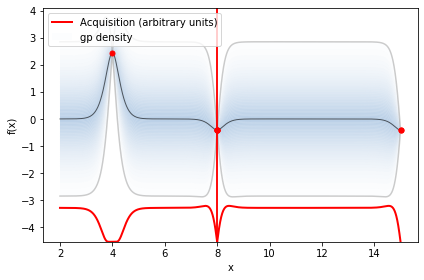

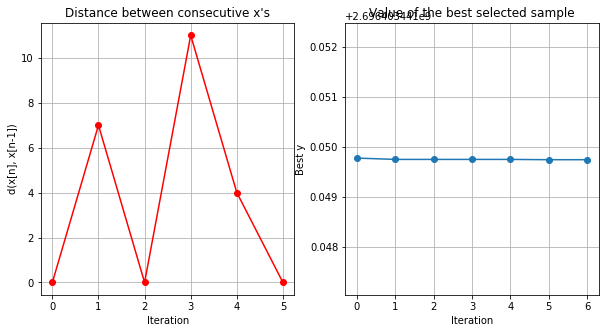

PWLF fit: label=2, nseg=2, R^2=0.9666755050588869
PWLF fit: label=3, nseg=3, R^2=0.9958581489770487
PWLF fit: label=4, nseg=4, R^2=0.9960994517951787
PWLF fit: label=5, nseg=5, R^2=0.996160740985432
PWLF fit: label=8 (opt), nseg=8, R^2=0.9961627005235939


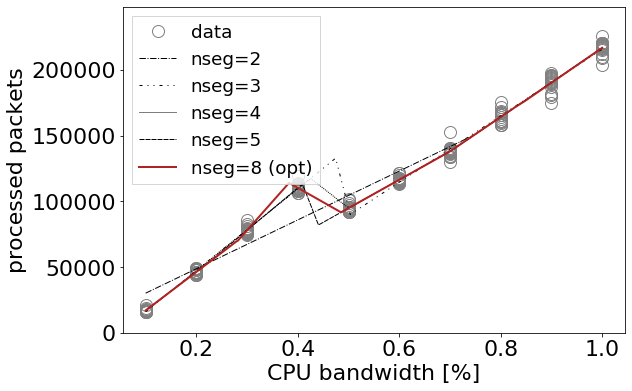

In [45]:
d = select(dfs[0].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec01", x_label="CPU bandwidth [%]", y_label="processed packets")

PWLF degree=1
Running optimizer ...
num acquisition: 1, time elapsed: 0.42s
num acquisition: 2, time elapsed: 110.39s
num acquisition: 3, time elapsed: 111.87s
num acquisition: 4, time elapsed: 179.16s
num acquisition: 5, time elapsed: 343.58s
num acquisition: 6, time elapsed: 350.35s
num acquisition: 7, time elapsed: 516.09s
num acquisition: 8, time elapsed: 686.61s
Optimum number of line segments: [9.]
Function value: 97176014.19350423


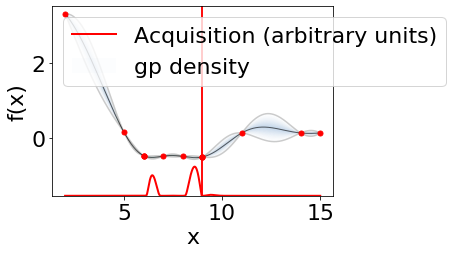

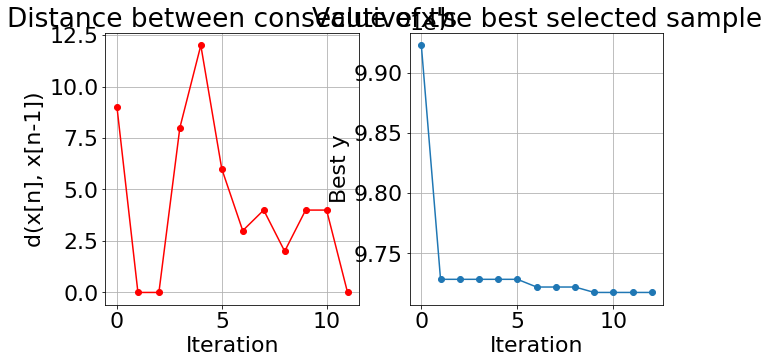

PWLF fit: label=2, nseg=2, R^2=0.9960328881624061
PWLF fit: label=3, nseg=3, R^2=0.996190179491336
PWLF fit: label=4, nseg=4, R^2=0.9963359187237933
PWLF fit: label=5, nseg=5, R^2=0.9964004897588612
PWLF fit: label=9 (opt), nseg=9, R^2=0.9964774866729987


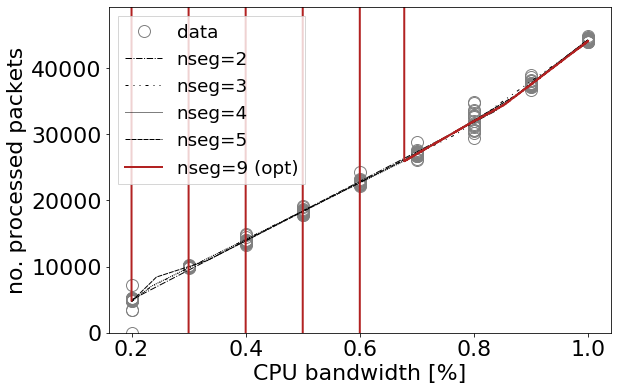

In [46]:
d = select(dfs[1].copy(), {"flow_size": 0, "ruleset": 2, "memory": 256})
analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec02", x_label="CPU bandwidth [%]", y_label="no. processed packets")

PWLF degree=1
Running optimizer ...
num acquisition: 1, time elapsed: 1.78s
num acquisition: 2, time elapsed: 3.53s
num acquisition: 3, time elapsed: 5.08s
num acquisition: 4, time elapsed: 6.51s
num acquisition: 5, time elapsed: 7.97s
num acquisition: 6, time elapsed: 9.49s
num acquisition: 7, time elapsed: 9.84s
num acquisition: 8, time elapsed: 13.39s
num acquisition: 9, time elapsed: 15.38s
num acquisition: 10, time elapsed: 17.04s
num acquisition: 11, time elapsed: 19.33s
num acquisition: 12, time elapsed: 20.97s
num acquisition: 13, time elapsed: 22.59s
num acquisition: 14, time elapsed: 23.96s
num acquisition: 15, time elapsed: 25.77s
num acquisition: 16, time elapsed: 27.88s
num acquisition: 17, time elapsed: 29.69s
num acquisition: 18, time elapsed: 31.08s
num acquisition: 19, time elapsed: 32.99s
num acquisition: 20, time elapsed: 34.77s
num acquisition: 21, time elapsed: 36.31s
num acquisition: 22, time elapsed: 38.26s
num acquisition: 23, time elapsed: 39.85s
num acquisitio

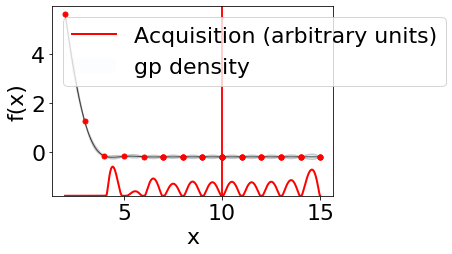

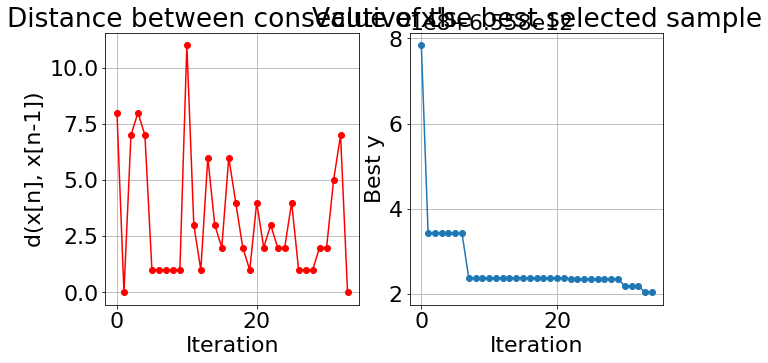

PWLF fit: label=2, nseg=2, R^2=0.999687592452907
PWLF fit: label=3, nseg=3, R^2=0.9997168530437395
PWLF fit: label=4, nseg=4, R^2=0.9997262340167297
PWLF fit: label=5, nseg=5, R^2=0.9997263573095091
PWLF fit: label=10 (opt), nseg=10, R^2=0.9997264751988911


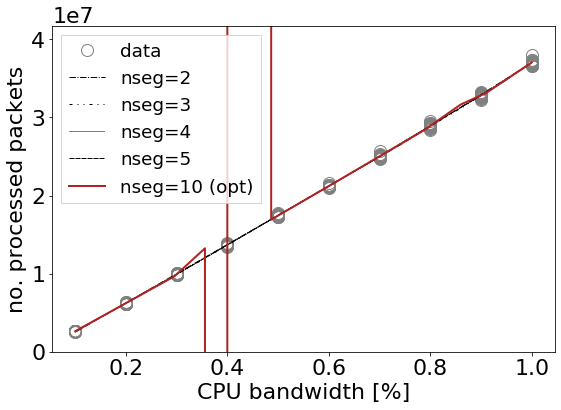

In [47]:
d = select(dfs[2].copy(), {"flow_size": 0, "ruleset": 0, "memory": 256})
analyse_fits(d, "cpu_bw", "ids_pkts", name="ds-sec03", x_label="CPU bandwidth [%]", y_label="no. processed packets")